# Some powerline can be disconnected, and there is ~~nothing~~ something you can do about it
Try this notebook out interactively with: [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/rte-france/Grid2Op/master)

<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">
Execute the cell below by removing the # character if you use google colab !

Cell will look like:
```python
!pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)
```
<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">




In [ ]:
# !pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)

To model the reality of powersystem operation and planning grid2op offers the possibility, when setting up an environment, to include powerline disconnection.

This is a really important part of the power system decision process. Indeed, when a powerline is being built it is often for more than a few decades (in some TSOs, some equipment was built and is still in service since almost 100 years ago!). Therefore, the **maintenance** of such equipment is important to model properly. In the case of grid2op, the **maitnenance** is modeled as a disconnection of a powerline and to block to reconnect this line for a given timespan. As this operation is planned you are given the relevant information in the observation:
- [`obs.time_next_maintenance`](https://grid2op.readthedocs.io/en/master/observation.html#grid2op.Observation.BaseObservation.time_next_maintenance) will give you, for each powerline, in how many time steps this powerline will be disconnected from the grid
- [`obs.duration_next_maintenance`](https://grid2op.readthedocs.io/en/master/observation.html#grid2op.Observation.BaseObservation.duration_next_maintenance) will give you, for each powerline, for how long (in number of time steps) this powerline will stay disconnected

The other important property of the powergrid is that they cover large areas, usually, they are the side of a whole country/state, for example, counting hundreds of thousands of "equipment" (varying in size from the tiny screws to fix two things together to wide transformers of the size of a building...). The probability, in these conditions, that any of this equipment fails is far from neglectable. For the record, the "failure" of equipment can have dozens of possible causes; for instance, it can be in a bad shape (not enough maintenance), it suffers from natural external aggression (wind storm, struck by lightning bolts, a tree falls on it, the external temperature is too hot causing some thermal issues, etc.), be the victim of a malicious attack (a person hack a piece of software or physically attack the equipment with a bulldozer or a bombing for example), or it is not operated outside of its standard operation range (human error, bad data are sent to the control center, etc.), or any other cause you can imagine. However, most of these possible causes have a common consequence which is that one or more powerlines will be disconnected from the grid. This is what we call **hazards** in the grid2op framework. Compared to maintenance, **hazards** are not predictable (nothing, before it happens, indicates that there will be such hazards in the next few time steps).

Actually, in our framework, we also added the capability to explicitly model attacks on the grid. We call this feature **Opponent**. For now, we model the opponent as an entity that can take, at each time step, the decision to disconnect a powerline. It has the same effect as the **hazards** (you know what it will do before it is happening) but is different in the following sense:

- **hazards** will refer to random unpredictable events (let's call it *natural failures*), they are, by essence, random
- **attack** (the action performed by an Opponent) will refer to possibly adversarial attacks, targeting equipment (not necessarily at random).


In both cases, you can know when a **maintenance**, a **hazard**, or an **attack** is happening if you look at the [`obs.time_before_cooldown_line`](https://grid2op.readthedocs.io/en/master/observation.html#grid2op.Observation.BaseObservation.time_before_cooldown_line) vector. It gives you, for each powerline, in how many time steps at **minimum** you need to wait before being able to reconnect a powerline. If this is 0 you can change its status. If this > 0 you need to wait for the appropriate number of time steps.

**NB** whether it's an attack, a hazard, or maintenance, the powerline will be automatic *disconnected*. They will stay *disconnected* until you reconnect them. This entails that if you don't reconnect them, they will remain disconnected.

# Handling maintenance

The following shows the effect of maintenances and how you can deal with them.

We start by loading an environment (here for test purpose) and reset it. We will study the powerline with id `56` because... why not. It is the line that goes from substations 26 to substation 30.

In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
import numpy as np

try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend


env = grid2op.make("l2rpn_wcci_2020", difficulty="0", test=True, backend=bk_cls())
plot_helper = PlotMatplot(env.observation_space)
env.seed(0)  # to get reproducible results
env.set_id(0)  # indicate to always read the same chronics, the first one
obs = env.reset()
do_nothing_action = env.action_space()
line_id = 56

c:\Users\thoma\anaconda3\envs\MA\Lib\site-packages\grid2op\Backend\pandaPowerBackend.py:32: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Users\thoma\anaconda3\envs\MA\python.exe -m pip install numba

  warnings.warn(
c:\Users\thoma\anaconda3\envs\MA\Lib\site-packages\grid2op\MakeEnv\Make.py:438: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)
c:\Users\thoma\anaconda3\envs\MA\Lib\site-packages\grid2op\Backend\backend.py:1848: RuntimeWarning: divide by zero encountered in divide
  p_s[sh_conn] *= (self._sh_vnkv[sh_conn] / sh_v[sh_conn]) ** 2
c:\Users\thoma\anaconda3\envs\MA\Lib\site-packages\grid2op\Backend\backend.py:1848: RuntimeWarning: invalid value encountered in multiply
  p_s[sh_conn] *= (self._sh_vnkv[sh_

In [2]:
print("The powerline id {} will be in maintenance in {} time steps. This maintenance will last for {} "\
      "consecutive timesteps".format(line_id, obs.time_next_maintenance[line_id], obs.duration_next_maintenance[line_id]))

The powerline id 56 will be in maintenance in 1260 time steps. This maintenance will last for 96 consecutive timesteps


Let's now skip a few time steps and define some action usefull for the next cells.

Can I act on the powerline 56 ? True
Is the powerline connected: True
The powerline id 56 will be in maintenance in 1 time steps. This maintenance will last for 96 consecutive timesteps


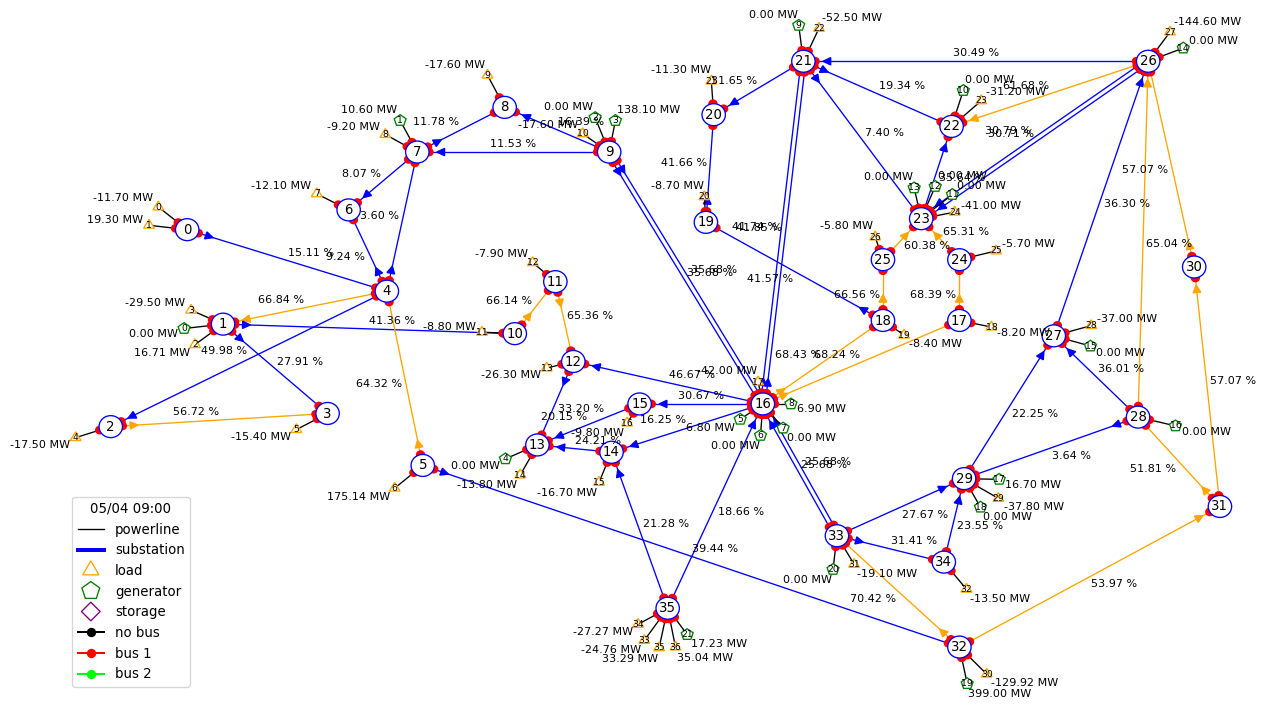

In [3]:
# first maintenance at 1260 (number of time step)
start_maintenance = 1259  

# define the action to reconnect it
reconnect_action = env.action_space({"set_line_status": [(line_id, +1)]})

# we skip a few time step, until the maintenance occur
env.fast_forward_chronics(start_maintenance)
# we get the observation at this very time steps
obs = env.get_obs()
print("Can I act on the powerline {} ? {}".format(line_id, obs.time_before_cooldown_line[line_id] == 0))
print("Is the powerline connected: {}".format(obs.line_status[line_id]))
print("The powerline id {} will be in maintenance in {} time steps. This maintenance will last for {} "\
      "consecutive timesteps".format(line_id,
                                     obs.time_next_maintenance[line_id],
                                     obs.duration_next_maintenance[line_id]))
_ = plot_helper.plot_obs(obs)

As you see, just before the maintenance is planned, the powerline is still connected (it is located in the top right corner of the graph, connect substation 26 to 30)

Now, let's see what happens in the first timestep where the powerline is in maintenance:

Can I act on the powerline? False
In how many time steps will I be able to reconnect it? 96
Is the powerline connected? False


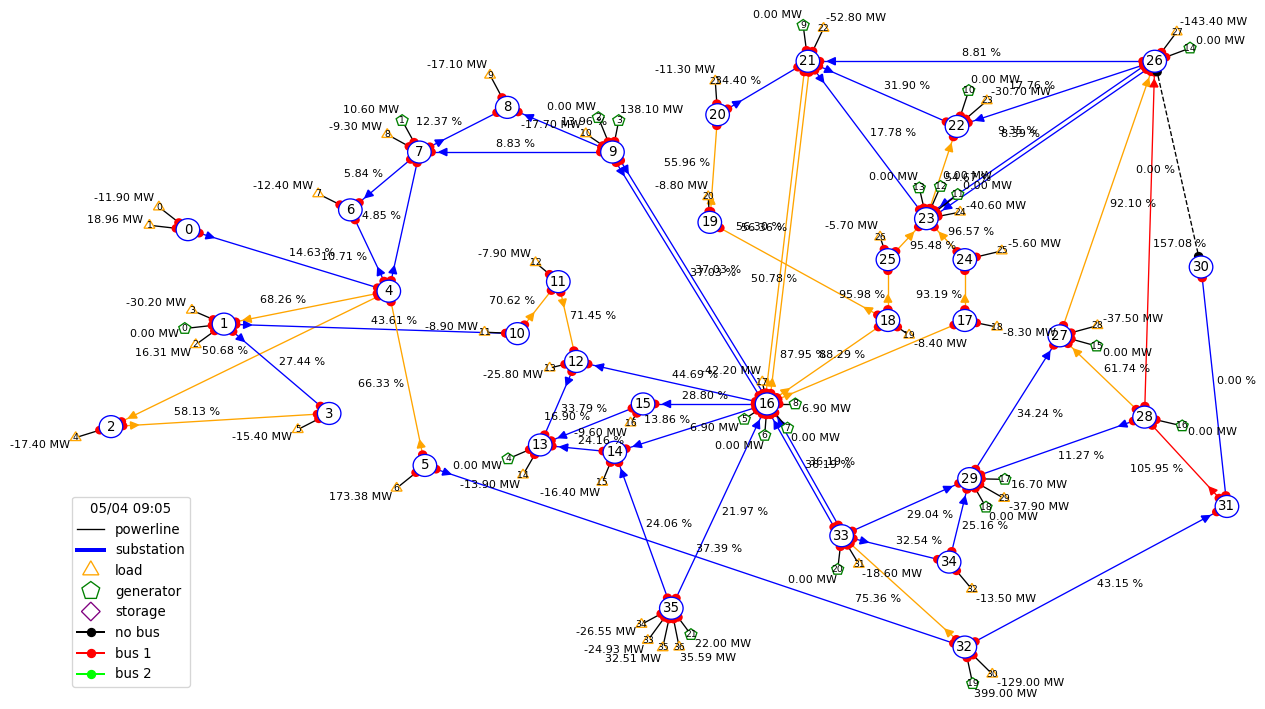

In [4]:
# one step pass
obs, reward, done, info = env.step(do_nothing_action)
print("Can I act on the powerline? {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time steps will I be able to reconnect it? {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected? {}".format(obs.line_status[line_id]))
_ = plot_helper.plot_obs(obs)

And now Tadaaa! You can see that the powerline is disconnected automatically (the powerline is dashed and black). By the way, this disconnection of the powerline has a very strong impact on the grid as it causes the overload of 2 other powerlines shown here in red (the from connecting substations 26 to 28 and the one connected substation 28 to 31).

For academic purposes, let's see what is happening if I try to reconnect it.

Can I act on the powerline? False
In how many time steps will I be able to reconnect it? 95
Is the powerline connected? False


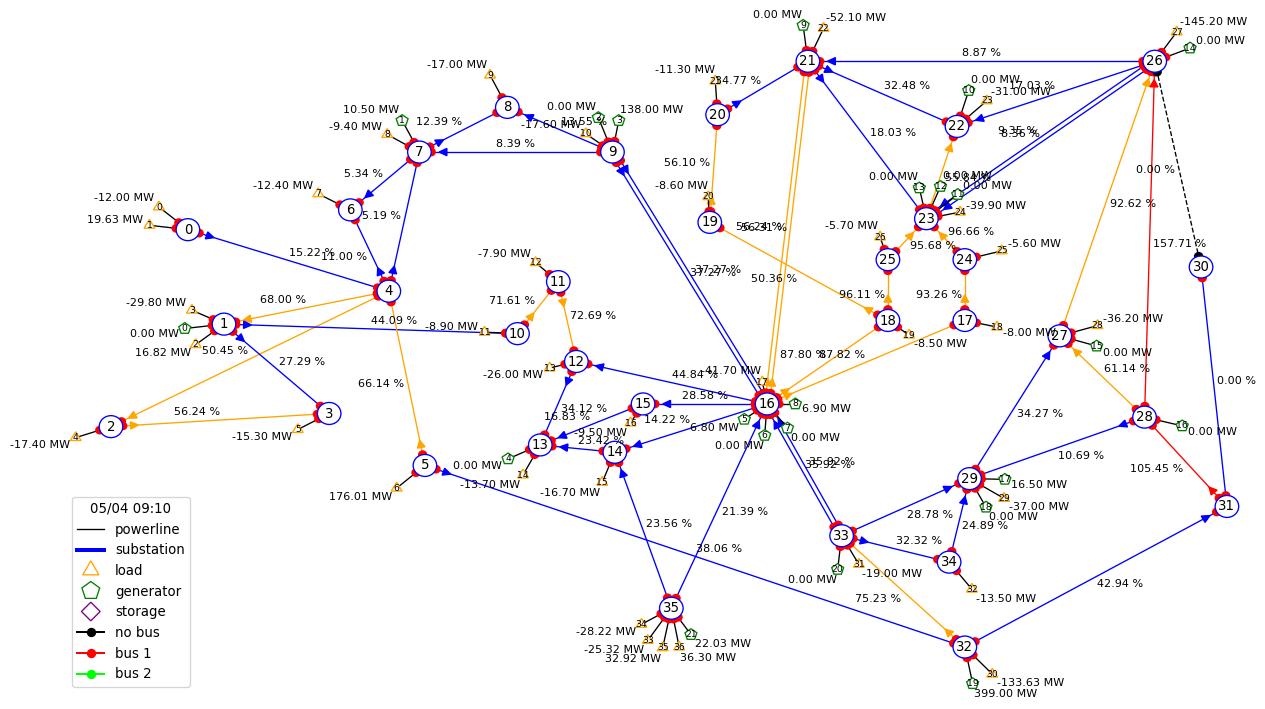

In [5]:
# let's try to reconnect the powerline
obs, reward, done, info = env.step(reconnect_action)
print("Can I act on the powerline? {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time steps will I be able to reconnect it? {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected? {}".format(obs.line_status[line_id]))
_ = plot_helper.plot_obs(obs)

Unfortunately for us, this has absolutely no effect. The maintenance is still happening, the powerline status is locked until the maintenance is over (in 95 time steps)

Let's then do nothing for 95 remaining time step (I have to wait for 95 timesteps before i am able to reconnect it.)

Can I act on the powerline? True
In how many time steps will I be able to reconnect it? 0
Is the powerline connected? False
The flow on it is 0.0A (of course because it is switched off)


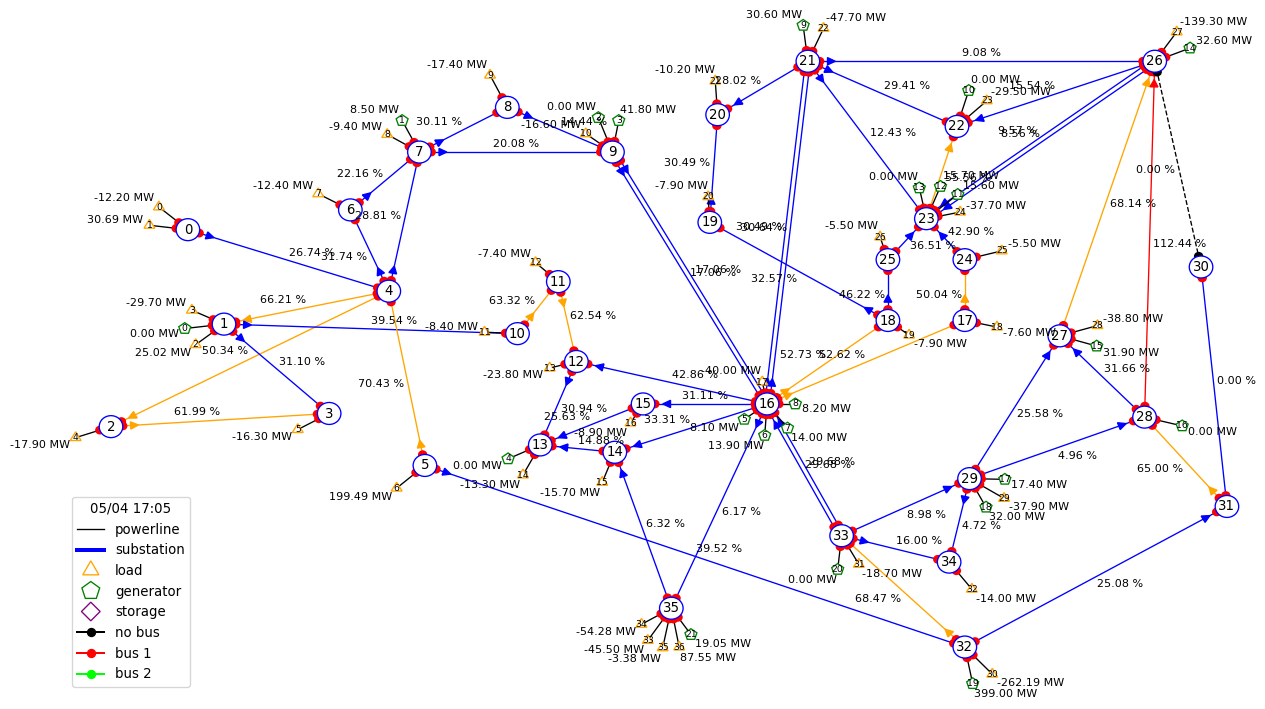

In [6]:
for _ in range(95):
    obs, reward, done, info = env.step(do_nothing_action)
print("Can I act on the powerline? {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time steps will I be able to reconnect it? {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected? {}".format(obs.line_status[line_id]))
print("The flow on it is {:.1f}A (of course because it is switched off)".format(obs.a_or[line_id]))
_ = plot_helper.plot_obs(obs)

As you can see, after the 95 time steps, the powerline can be reconnected (information printed), but that does not mean it is reconnected. Actually, it is not reconnected until you do it. 

For example, we can do a few more steps, and you will see the powerline still has not to be reconnected.

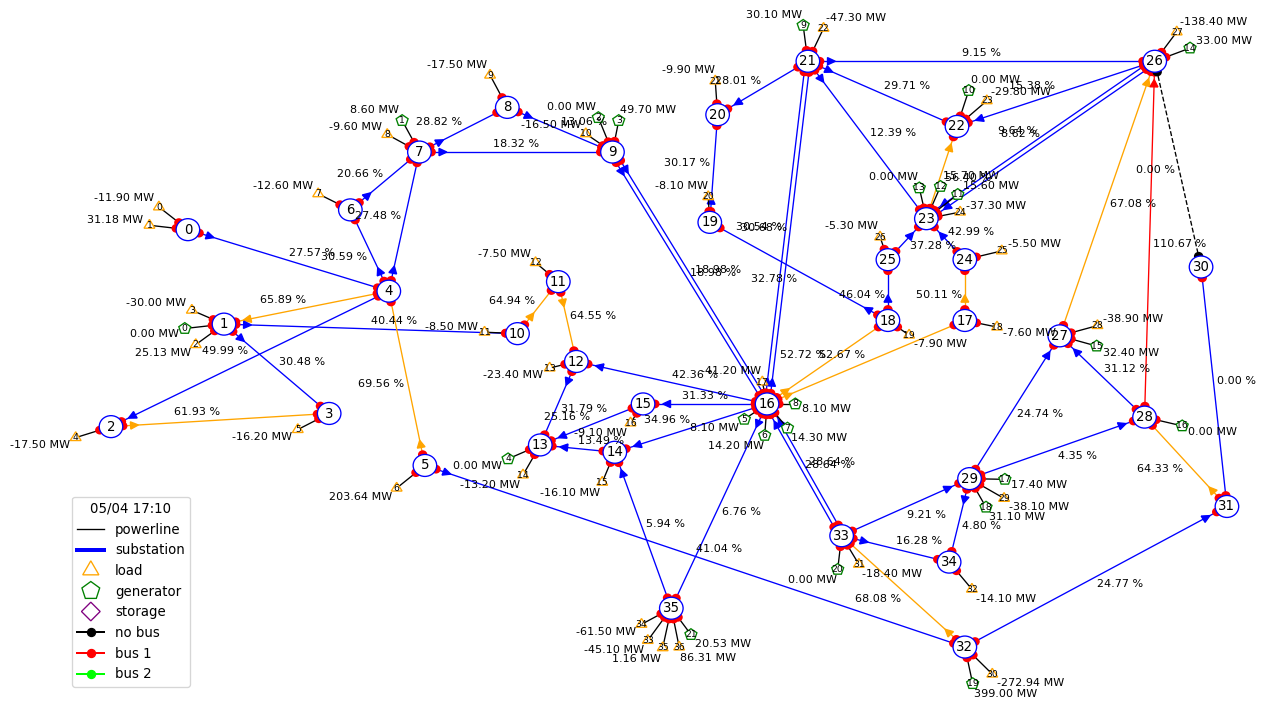

In [7]:
obs, reward, done, info = env.step(do_nothing_action)
_ = plot_helper.plot_obs(obs)

But now (we could have done that the preceeding time steps though) the powerline can be reconnected. Let us do it and see the resulting grid.

Can I act on the powerline? True
In how many time steps will I be able to reconnect it? 0
Is the powerline connected? True
The flow on it is 166.7A


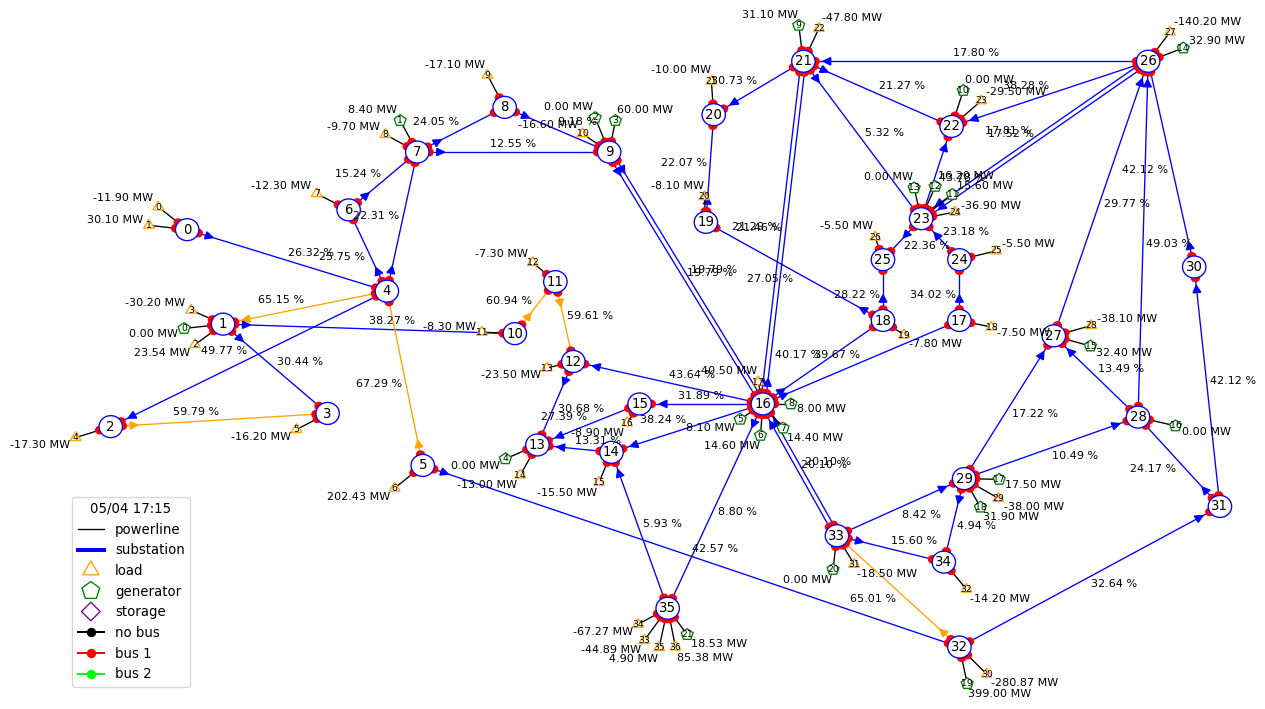

In [8]:
# and now reconnect it
obs, reward, done, info = env.step(reconnect_action)
print("Can I act on the powerline? {}".format(obs.time_before_cooldown_line[line_id] == 0))
print("In how many time steps will I be able to reconnect it? {}".format(obs.time_before_cooldown_line[line_id]))
print("Is the powerline connected? {}".format(obs.line_status[line_id]))
print("The flow on it is {:.1f}A".format(obs.a_or[line_id]))
_ = plot_helper.plot_obs(obs)

**SUCCESS**: the powerline has been properly reconnected, and everything on this part of the grid is now in order.

# Hazards / Opponent

In some settings you also have a "purely stochastic" component directly embeded into the environment. It is called an "Opponent" and will disconect (at random most of the time) some powerlines.

c:\Users\thoma\anaconda3\envs\MA\Lib\site-packages\grid2op\MakeEnv\Make.py:438: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


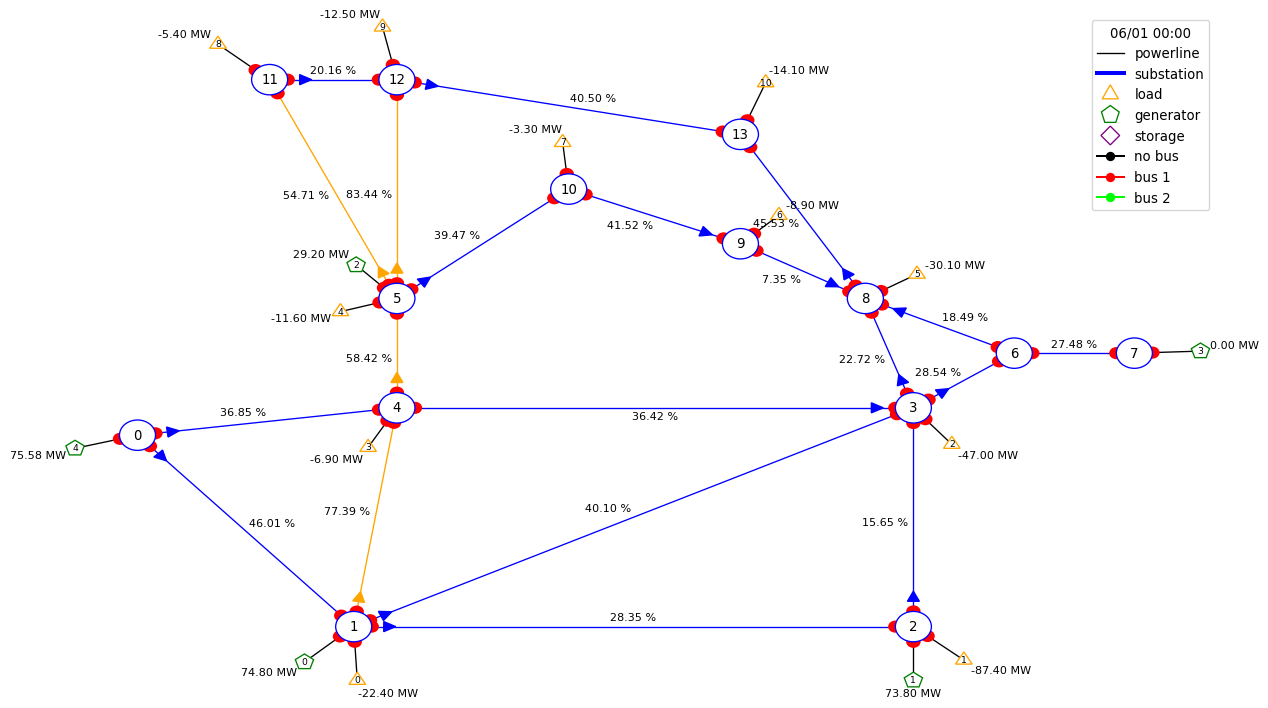

In [9]:
import numpy as np
import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Parameters import Parameters
# i will disable the powerline disconnection in case of overflow
param = Parameters()
param.NO_OVERFLOW_DISCONNECTION = True
env_name2 = "rte_case14_opponent"
env_opp = grid2op.make(env_name2, test=True, param=param, backend=bk_cls())
plot_helper_opp = PlotMatplot(env_opp.observation_space)
line_id_opp = 3
reconnect_action_opp = env_opp.action_space({"set_line_status": [(line_id_opp, +1)]})
do_nothing_opp = env_opp.action_space()
env_opp.seed(0)  # make sure i have reproducible experiments
obs = env_opp.reset()
_ = plot_helper_opp.plot_obs(obs)

We know (but that is because we set the seed and because we coded this environment) that an attack will happen at time step 96 so we do_nothing until that time. And, to be transparent, we show the state of the powergrid.

The next maintenance is schedule in -1 time steps (-1 = never)


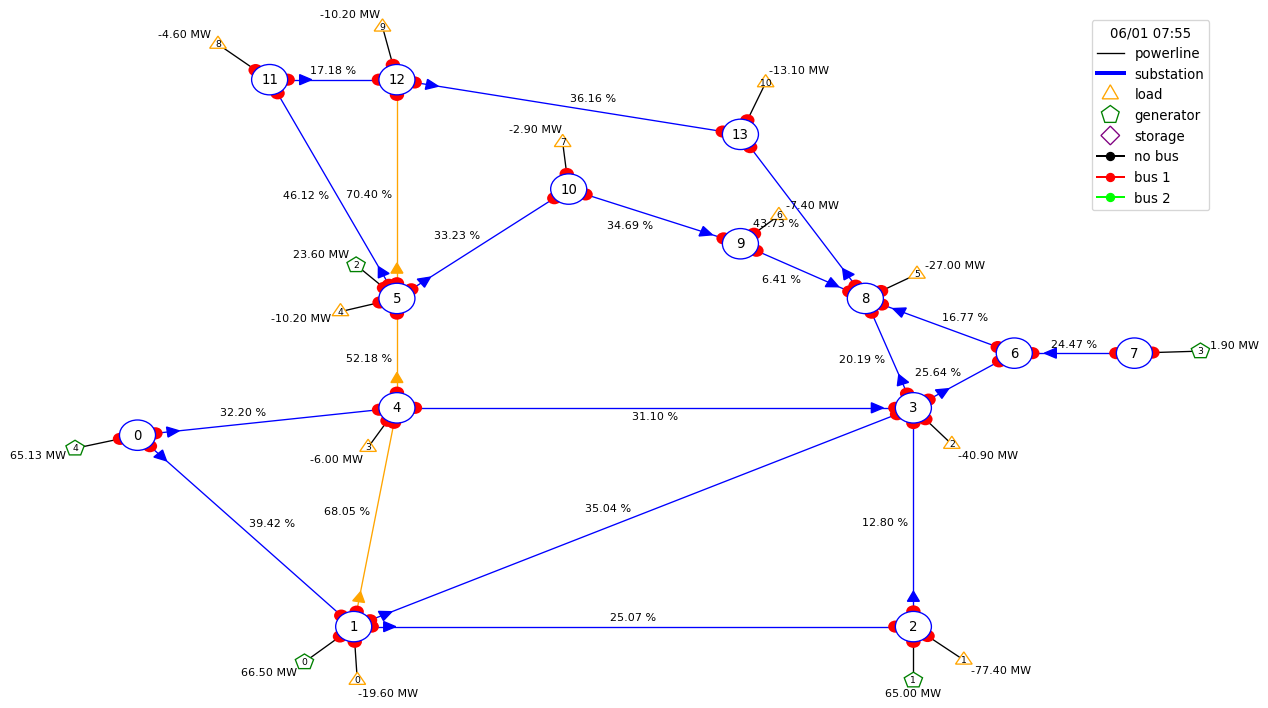

In [10]:
for i in range(95):
    obs, reward, done, info = env_opp.step(do_nothing_opp)
print("The next maintenance is schedule in {} time steps (-1 = never)"\
      "".format(obs.time_next_maintenance[line_id_opp]))
_ = plot_helper_opp.plot_obs(obs)

Now let's do another step. Note that not maintenance are planned for the forseeable future, yet a powerline will be disconnected.

The next maintenance is schedule in -1 time steps (-1 = never)
The flow on this powerline is 0.0%
This powerline is unavailable for 47 time steps
I can also spot an attack by looking at the "info" dictionnary, that tells me that an attack is taking place on powerline: [3], and this attack will last 48 time steps (in total, it started this time step so it will be over in 47 = 48 - 1 time steps).


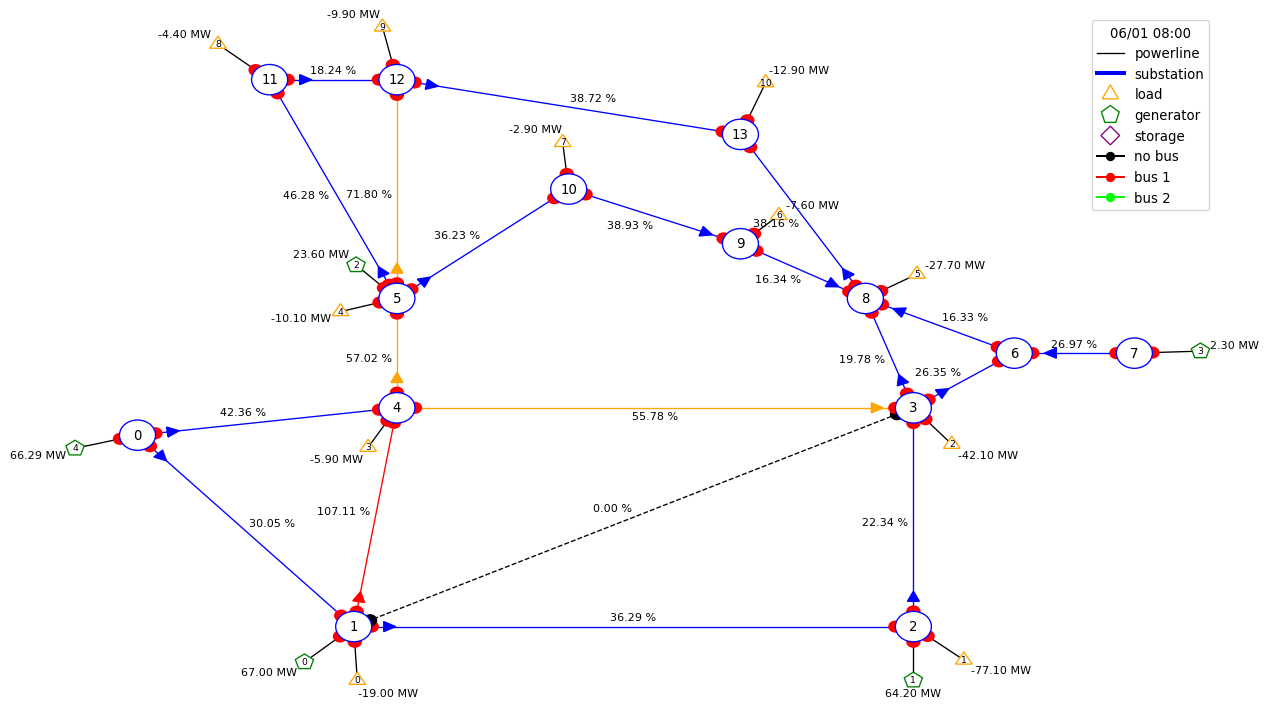

In [11]:
obs, reward, done, info = env_opp.step(do_nothing_opp)
_ = plot_helper_opp.plot_obs(obs)
print("The next maintenance is schedule in {} time steps (-1 = never)"\
      "".format(obs.time_next_maintenance[line_id_opp]))
print("The flow on this powerline is {:.1f}%"\
      "".format(100*obs.rho[line_id_opp]))
print("This powerline is unavailable for {} time steps".format(obs.time_before_cooldown_line[line_id_opp]))
print("I can also spot an attack by looking at the \"info\" dictionnary, that tells me that an attack is taking " \
      "place on powerline: {}, and this attack will last {} time steps (in total, it started this time step "\
      "so it will be over in 47 = 48 - 1 time steps)." \
      "".format(np.where(info["opponent_attack_line"])[0], info["opponent_attack_duration"]))

We have been victim of an "attack" on the grid. The powerline 3, connecting substation 1 to substation 3 is now out of service for 47 time steps. As it was the case for maintenance, any attempt to reconnect it will fail, as shown in the image bellow

The powerline will be unavailble for again 46 time steps.


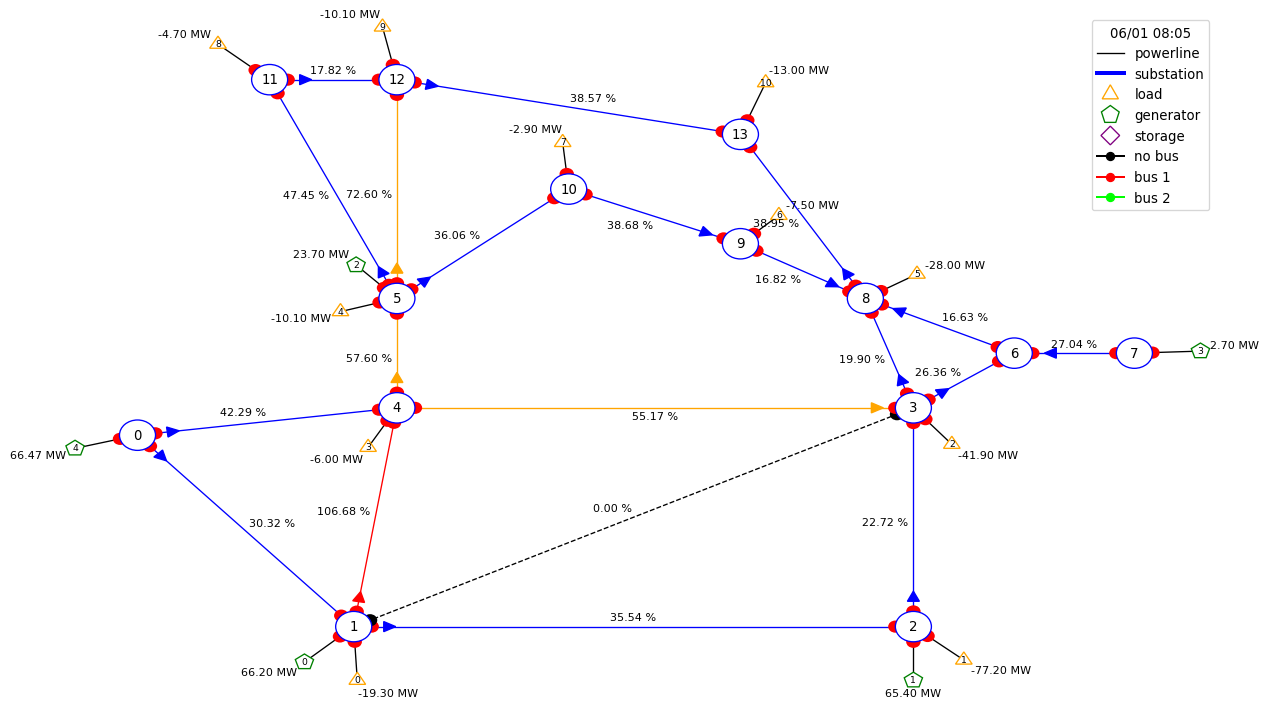

In [12]:
obs, reward, done, info = env_opp.step(do_nothing_opp)
_ = plot_helper_opp.plot_obs(obs)
print("The powerline will be unavailble for again {} time steps."\
      "".format(obs.time_before_cooldown_line[line_id_opp]))

There is nothing really interesting in here, so we will do nothing for 46 time steps

The next maintenance is schedule in -1 time steps (-1 = never)
The powerline will be unavailble for again 0 time steps.


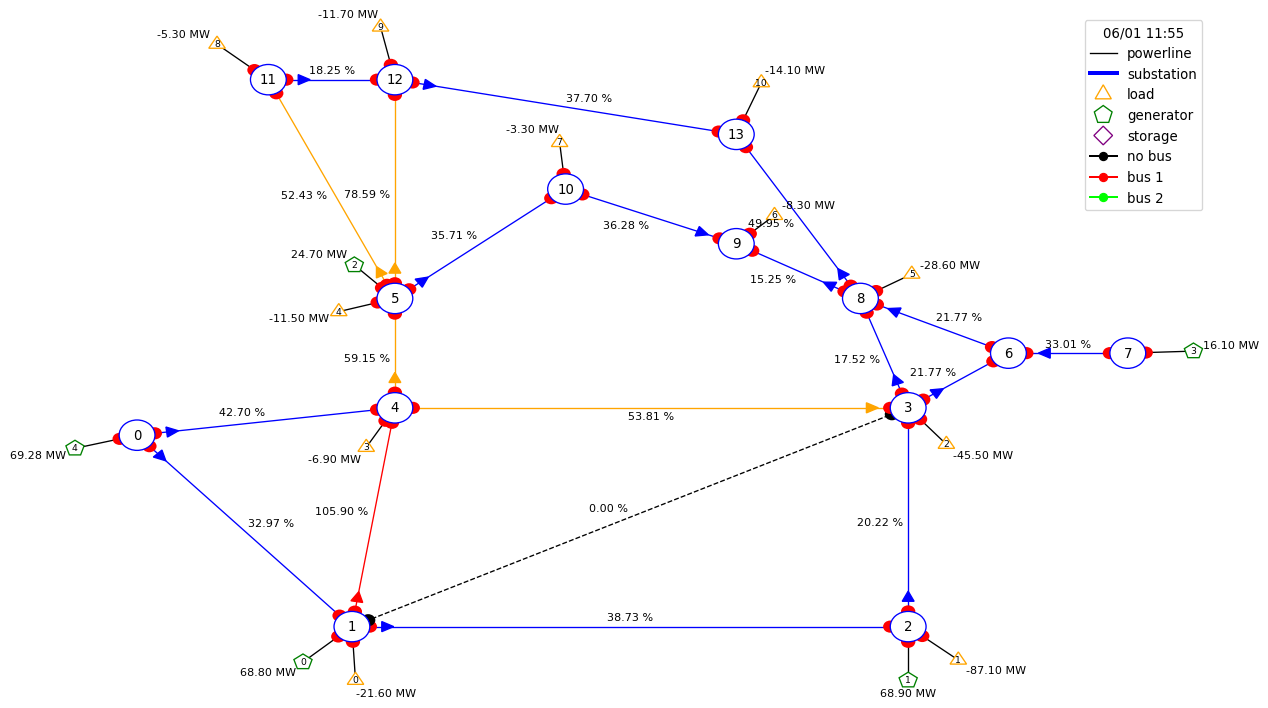

In [13]:
for i in range(46):
    obs, reward, done, info = env_opp.step(do_nothing_opp)
_ = plot_helper_opp.plot_obs(obs)
print("The next maintenance is schedule in {} time steps (-1 = never)"\
      "".format(obs.time_next_maintenance[line_id_opp]))
print("The powerline will be unavailble for again {} time steps."\
      "".format(obs.time_before_cooldown_line[line_id_opp]))

As for the maintenance, we see here that the powerline can be reconnected (`obs.time_before_cooldown_line[line_id_opp] = 0`), but it has not been reconnected automatically (it is still disconnected). But hopefully, now we know how to reconnect them, what we'll do in the next, concluding this notebook.

The powerline will be unavailble for again 0 time steps.


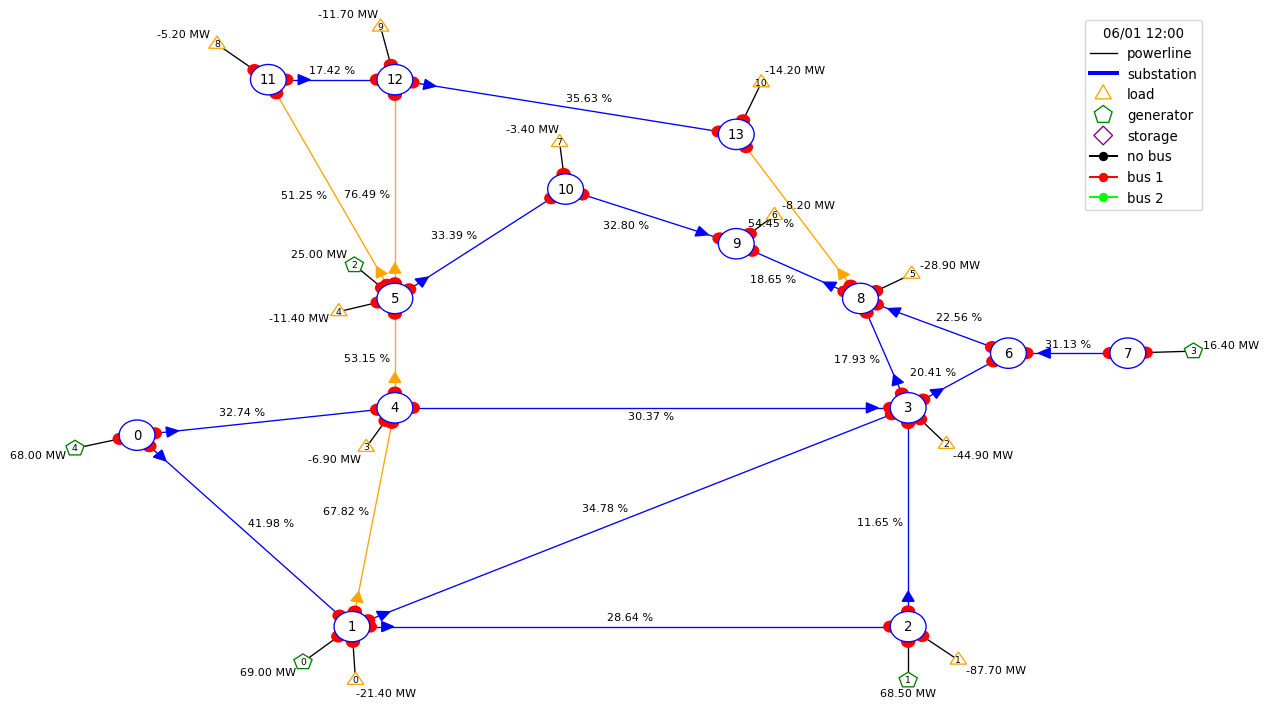

In [14]:
obs, reward, done, info = env_opp.step(reconnect_action_opp)
_ = plot_helper_opp.plot_obs(obs)
print("The powerline will be unavailble for again {} time steps."\
      "".format(obs.time_before_cooldown_line[line_id_opp]))